## Example code for SCA talk

In [11]:
# boilerplate imports + data ingestion

%matplotlib inline
from fish.image.vol import InterpArray
import matplotlib.pyplot as plt
from h5py import File
from fish.image.zds import ZDS
from scipy.ndimage.filters import median_filter
import numpy as np
import dask.array as da

base_dir = '/nrs/ahrens/Yu/SPIM/active_dataset/GliaNeuron/20170221/fish4/20170221_4_3_gfaprgeco_hucgc_6dpf_wholebrain_faster_brighter_20170221_174442_noephys/'
dset = ZDS(base_dir + 'raw/')
data = dset.data
exp_name = base_dir.split('/')[-2]
reg_dir = f'/groups/ahrens/ahrenslab/davis/tmp/{exp_name}/'
reg_path = reg_dir + 'regparams_affine.npy'
fs_im = dset.metadata['volume_rate']
shifts = -np.load(reg_path)[:,:-1,-1]

def shift_yx(im, shifts, block_id):
    from scipy.ndimage.interpolation import shift
    t = block_id[0] 
    im_ = im
    if im.dtype == 'float16':
        im_ = im.astype('float32')
    return shift(im_, (0,0, *shifts[t]), order=1, cval=100).astype(im.dtype)


In [13]:
# the full size of the dataset
data.shape

(6013, 22, 2048, 2048)

In [5]:
%%time
# define an ROI (Time, Z, Y, X)
roi = slice(None), slice(10,None), slice(1024,None), slice(None)

# median filter
data_filt = data[roi].astype('float32').map_blocks(lambda v: median_filter(v, size=(1,1,3,3)), dtype='float32')

# motion correction
data_tx = data_filt.map_blocks(shift_yx, shifts, dtype='float32')

# this is our downsampled dff data, defined as a hdf5 file that acts like an in-memory array
baseline_y = da.from_array(File(reg_dir + 'ds_baseline.h5', libver='latest', mode='r')['baseline'], chunks=(1,-1,-1,-1))

# the hdf5 file also contains the timepoints used for downsampling
baseline_x = File(reg_dir + 'ds_baseline.h5', mode='r')['keyframes'][:]

# we use the baseline and the timepoints to define an InterpArray
dsb = InterpArray(x=baseline_x, y=baseline_y, full_shape=data.shape, interpolation_axis=0)

# We get our lazy baseline by indexing the InterpArray with the ROI
baseline = dsb[roi]

# because we are using dask, we can define the df/f operation using basic math operators and get a lazy result
data_dff = (data_tx / baseline) - 1

CPU times: user 15.6 s, sys: 109 ms, total: 15.7 s
Wall time: 15.8 s


In [6]:
data_dff.shape

(6013, 12, 1024, 2048)

## Get Δf/f image of first and last timepoints at full resolution using a single worker (no distributed computation)

In [7]:
%%time
# this does everything -- load, filter, align, normalize, all for one image
dff_first = data_dff[0].compute(scheduler='threads')

CPU times: user 11.8 s, sys: 377 ms, total: 12.2 s
Wall time: 13.8 s


In [8]:
%%time
dff_last = data_dff[-1].compute(scheduler='threads')

CPU times: user 12 s, sys: 767 ms, total: 12.8 s
Wall time: 16.1 s


## Show max projections of Δf/f volumes

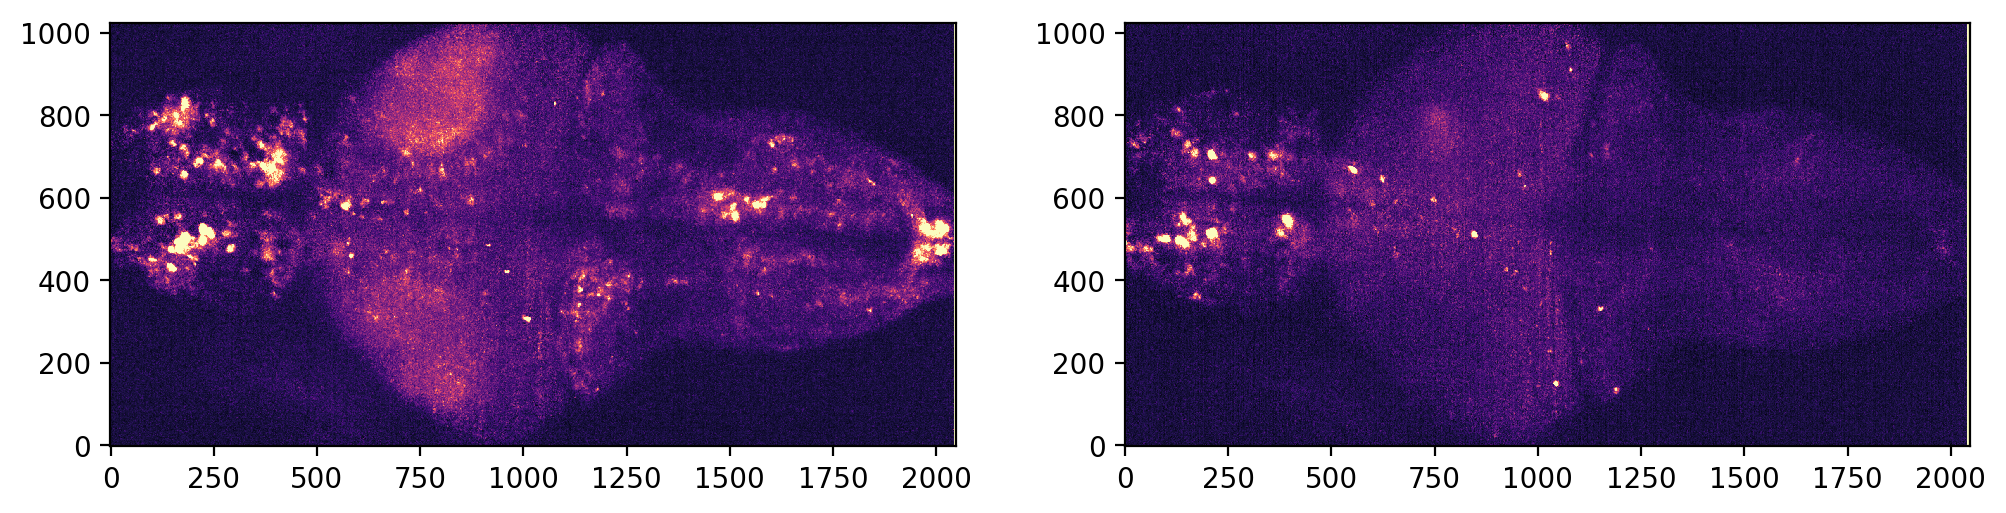

In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(12,12), dpi=200)
axs[0].imshow(dff_first.max(0), clim=(0,.2), cmap='magma', origin='lower')
axs[1].imshow(dff_last.max(0), clim=axs[0].images[0].get_clim(), cmap='magma', origin='lower')